<a href="https://colab.research.google.com/github/adefgreen98/NLU2021-Assignment2/blob/main/code/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Understanding 2021 - Assignment 2: NERs & Dependency Parsing

_Federico Pedeni, 223993_

### Setup


In [1]:
!git clone https://github.com/adefgreen98/NLU2021-Assignment2.git
!mv /content/NLU2021-Assignment2/code/conll.py ./

Cloning into 'NLU2021-Assignment2'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 38 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [2]:
import zipfile
# Extract assignment data
with zipfile.ZipFile("NLU2021-Assignment2/data/conll2003.zip") as zipref:
    zipref.extractall('data')

### Requirements

In [3]:
import spacy
import nltk

import itertools 
from conll import *

In [4]:
# Initialize parser
nlp = spacy.load('en')

In [5]:
# Format of dataset: <TOKEN> <POS> <IOB part-of speech tag> <TAG>


def load_dataset(mode):
    res = {
        'sentences': [],
        'ners': []
    }
    pth = f'data/{mode}.txt'
    
    idx = 0

    tmpsentence = []
    tmpentity = {}
    tmp_entities_in_sentence = []

    tmpmisc = None

    with open(pth, 'rt') as file:
        for line in file:
            idx += 1
            if line == '\n':
                if len(tmpsentence) > 0:
                    # adding artificial punctuation for only nominal sentences so that they are correclty parsed
                    # if tmpsentence[-1] != '.': 
                    #     tmpsentence.append('.')

                    # flushes the current sentence
                    res['sentences'].append(' '.join(tmpsentence))
                    tmpsentence = []

                    # flushes the last entity in entity list for sentence
                    if len(tmpentity) > 0: tmp_entities_in_sentence.append(tmpentity)
                    tmpentity = []
                    
                    # adds artificial punctuation if needed also to the entity list
                    # if tmp_entities_in_sentence[-1][-1][0] != '.':
                    #     tmp_entities_in_sentence.append([('.', 'O')])
                    
                    # flushes entity list
                    res['ners'].append(tmp_entities_in_sentence)
                    tmp_entities_in_sentence = []
                continue
            elif line.startswith('-DOCSTART-'):
                continue
            else:
                if len(line.split()) != 4: 
                    print(f"Error: line with size {len(line.split())} at index {index}")
                token, pos, tag1, tag2 = line.split()
                tmpsentence.append(token)

                if tag2.startswith('B'):
                    if len(tmpentity) > 0:
                        tmp_entities_in_sentence.append(tmpentity)
                        tmpentity = [(token, tag2)]
                    else:
                        tmpentity = [(token, tag2)]
                elif tag2.startswith('I'):
                    currtag = tag2.split('-')[1]
                    oldtag =  tmpentity[-1][1].split('-')[1]
                    if currtag != oldtag: 
                        raise RuntimeError(f"not corresponding tags at index {idx}; tags are '{currtag}' (new) and '{oldtag}' (old)")
                    tmpentity.append((token, tag2))
                elif tag2.startswith('O'): 
                    if len(tmpentity) > 0: tmp_entities_in_sentence.append(tmpentity)
                    tmpentity = [(token, tag2)]
                else:
                    print(f"Error: wrong tag detected at line {idx}, line: {line.encode()}")

    # TODO: solve the issue of MISC tagged-tokens that seem compound but appear without a subject (eg: 'German', 'British')
    return res


### Named entity lanbels conversion from SpaCy format to CoNLL format
Labelmaps converted to CoNLL according to [this](https://www.clips.uantwerpen.be/conll2003/ner/annotation.txt).

In [6]:
for el in nlp.entity.labels:
    print(el, ": ", spacy.explain(el))

CARDINAL :  Numerals that do not fall under another type
DATE :  Absolute or relative dates or periods
EVENT :  Named hurricanes, battles, wars, sports events, etc.
FAC :  Buildings, airports, highways, bridges, etc.
GPE :  Countries, cities, states
LANGUAGE :  Any named language
LAW :  Named documents made into laws.
LOC :  Non-GPE locations, mountain ranges, bodies of water
MONEY :  Monetary values, including unit
NORP :  Nationalities or religious or political groups
ORDINAL :  "first", "second", etc.
ORG :  Companies, agencies, institutions, etc.
PERCENT :  Percentage, including "%"
PERSON :  People, including fictional
PRODUCT :  Objects, vehicles, foods, etc. (not services)
QUANTITY :  Measurements, as of weight or distance
TIME :  Times smaller than a day
WORK_OF_ART :  Titles of books, songs, etc.


In [7]:

# Labelmaps converted to CoNLL according to https://www.clips.uantwerpen.be/conll2003/ner/annotation.txt
labelmap = {
    'CARDINAL': 'out',
    'DATE': 'out',
    'EVENT': 'MISC',
    'FAC': 'LOC',
    'GPE': 'LOC',
    'LANGUAGE': 'MISC',
    'LAW': 'out',
    'LOC': 'LOC',
    'MONEY': 'out',
    'NORP': 'MISC',
    'ORDINAL': 'out',
    'ORG': 'ORG',
    'PERCENT': 'out',
    'PERSON': 'PER',
    'PRODUCT': 'out',
    'QUANTITY': 'out',
    'TIME': 'out',
    'WORK_OF_ART': 'out',
    '': 'out'
}

def convert_tag(tk:spacy.tokens.Token):
    return (tk.ent_iob_ + ('-' + labelmap[tk.ent_type_])) if labelmap[tk.ent_type_] != 'out' else 'O'

In [8]:
dataset = load_dataset('test')

In [9]:
for sent, ents in zip(dataset['sentences'][:4], dataset['ners'][:4]):
    print("Sentence: ", sent)
    print("Ents: ", *ents, sep='\n')
    print("----------------------------")

Sentence:  SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
Ents: 
[('SOCCER', 'O')]
[('-', 'O')]
[('JAPAN', 'B-LOC')]
[('GET', 'O')]
[('LUCKY', 'O')]
[('WIN', 'O')]
[(',', 'O')]
[('CHINA', 'B-PER')]
[('IN', 'O')]
[('SURPRISE', 'O')]
[('DEFEAT', 'O')]
[('.', 'O')]
----------------------------
Sentence:  Nadim Ladki
Ents: 
[('Nadim', 'B-PER'), ('Ladki', 'I-PER')]
----------------------------
Sentence:  AL-AIN , United Arab Emirates 1996-12-06
Ents: 
[('AL-AIN', 'B-LOC')]
[(',', 'O')]
[('United', 'B-LOC'), ('Arab', 'I-LOC'), ('Emirates', 'I-LOC')]
[('1996-12-06', 'O')]
----------------------------
Sentence:  Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .
Ents: 
[('Japan', 'B-LOC')]
[('began', 'O')]
[('the', 'O')]
[('defence', 'O')]
[('of', 'O')]
[('their', 'O')]
[('Asian', 'B-MISC'), ('Cup', 'I-MISC')]
[('title', 'O')]
[('with', 'O')]
[('a', 'O')]
[('lucky', 'O')]
[('2-1', 'O')]
[('win', 'O')]
[('ag

### 1) Evaluate spaCy NER model using CoNLL evaluation script on CoNLL 2003 data 


In [10]:

# Unique set of mapping labels to indexes (needed for sklearn.metrics.classification_report())
# - (converted to dict for better performance, otherwise at each step would be needed list.index(token))
__index_labels__ = [el[0] + el[1] for el in itertools.product(['B-', 'I-'], ['LOC', 'MISC', 'ORG', 'PER'])] + ['O']
__index_labels__ = {lab: idx for lab,idx in zip(__index_labels__, range(len(__index_labels__)))}


def get_accuracies(doc:spacy.tokens.Doc, ents:list, labels=__index_labels__):
    gt_sent = [
        # all tokens in a sentence
        [enttoken[0] for ent in ents for enttoken in ent], 
        # relative entity tags 
        [enttoken[1] for ent in ents for enttoken in ent]
    ]

    # needed for part 1
    preds = []
    truths = []

    # needed for part 2
    parsed_sent = []
    
    # Multi-token entity container
    tmpentity = ['', None]

    for tk in doc:
        # Init. variable that will be either token text or multi-token-entity concatenated tokens
        text = None
        
        # label converted according to CoNLL standard (or 'O' when is not part of an entity)
        conv_label = convert_tag(tk)

        # MULTI-TOKEN ENTITY JOIN
        if len(tk.whitespace_) == 0: # current multi-entity must be expanded
            tmpentity[0] += tk.text
            if tmpentity[1] is None: tmpentity[1] = conv_label
            else:
                if tmpentity[1] != conv_label:
                    if tmpentity[1] == 'O' or conv_label == 'O':
                        pass
                    else:
                        if tmpentity[1].split('-')[1] != conv_label.split('-')[1]: raise ValueError("not matching labels for sentence {}".format(sent))
            
            if tk.i == (len(doc) - 1): # last multi-token entity of the sentence
                text = tmpentity[0]
                conv_label = tmpentity[1]
                tmpentity = ['', None]
            else:
                continue
        else:
            if len(tmpentity[0]) > 0: # cached multi-token entity is finished
                tmpentity[0] += tk.text
                if tmpentity[1] != conv_label:
                    # since there are very very few (5 in test.txt) cases where multi-token entities have different tags, a rough conversion is simply applied 
                    conv_label = tmpentity[1] 
                            
                text = tmpentity[0]
                conv_label = tmpentity[1]
                tmpentity = ['', None]
            else: # no multi-token entity cached
                text = tk.text
                conv_label = conv_label
        
        # finds correct index in sentence tokens
        idx = gt_sent[0].index(text)
        # finds corresponding ground truth
        gt = gt_sent[1][idx]

        # Part 1
        preds.append(labels[conv_label])
        truths.append(labels[gt])

        # Part 2
        parsed_sent.append((text, conv_label))
    
    return {'part1': {'preds': preds, 'truths': truths}, 'part2': parsed_sent}



### 2) Grouping of Entities. Write a function to group recognized named entities using noun_chunks method of spaCy. Analyze the groups in terms of most frequent combinations (i.e. NER types that go together).



In [11]:
def group_ents(doc:spacy.tokens.Doc):

    res = [] # current sentence
    
    noun_chunks = list(doc.noun_chunks)
    entities = list(doc.ents)
    
    i = 0 # index for entities
    j = 0 # index for noun_chunks
    
    # iterating jointly over entities and noun chunks
    while i < len(entities) and j < len(noun_chunks):
        
        # if len(entities[i]) > len(noun_chunks[j]): raise ValueError("mismatch with ents {} and nchunks {}".format(entities[i], noun_chunks[j]))

        # forward check on outliers entities (outside noun_chunks)
        if entities[i][0] not in noun_chunks[j]: # if 1st token is not in current nchunk
            
            if (len(res) == 0 or (len(res) > 0 and len(res[-1]) > 0)): res.append([]) # start a new group, bc current one is finished

            tmp = j
            
            while tmp < len(noun_chunks): # NOTE: supposing all items in entity belong to same noun chunk if they belong to one!!!
                if entities[i][0] in noun_chunks[tmp]: break
                else: tmp += 1

            if tmp == len(noun_chunks): # entity is an outlier or current noun chunk does not contain entities
                if len(res) > 0 and len(res[-1]) == 0: res[-1].append(entities[i][0].ent_type_) 
                else: res.append([entities[i][0].ent_type_])
                if i != len(entities) - 1: res.append([]) # prepares new group (for subsequent eventually not outliers)
                i += 1
            else: pass # will be explored later
        else:
            if len(res) == 0: res.append([entities[i][0].ent_type_]) # meaning this is the first entity of a noun chunk | NOTE: supposing all items in entity have the same label!!!
            else: res[-1].append(entities[i][0].ent_type_) # here i have already started a noun chunk, so i must append (--> actually a combination)
            i += 1
            j -= 1

        if j == len(noun_chunks) - 1:
            while i < len(entities):
                if len(res[-1]) == 0: res[-1].append(entities[i][0].ent_type_)
                else: res.append([entities[i][0].ent_type_])
                i += 1
        j += 1
    
    return res

### Results of Exercises

#### **Exercise 1**

In [12]:

results_ex1 ={
    'part1': {'preds': [], 'truths': []},
    'part2': []
}

results_ex2 = []

for sent, ents in zip(dataset['sentences'], dataset['ners']):
    doc = nlp(sent)
    res = get_accuracies(doc, ents)
    results_ex1['part1']['truths'].extend(res['part1']['truths'])
    results_ex1['part1']['preds'].extend(res['part1']['preds'])
    results_ex1['part2'].append(res['part2'])

    results_ex2.append(group_ents(doc))


+ report token-level performance (per class and total)
> + accuracy of correctly recognizing all tokens that belong to named entities (i.e. tag-level accuracy)


In [13]:
import sklearn
from sklearn.metrics import classification_report

print(classification_report(results_ex1['part1']['truths'], results_ex1['part1']['preds'], target_names=list(__index_labels__.keys())))

              precision    recall  f1-score   support

       B-LOC       0.78      0.73      0.75      1666
      B-MISC       0.80      0.56      0.66       706
       B-ORG       0.52      0.34      0.41      1658
       B-PER       0.78      0.62      0.69      1615
       I-LOC       0.53      0.59      0.56       257
      I-MISC       0.59      0.37      0.46       214
       I-ORG       0.43      0.53      0.47       812
       I-PER       0.73      0.77      0.75      1158
           O       0.95      0.98      0.97     38349

    accuracy                           0.91     46435
   macro avg       0.68      0.61      0.64     46435
weighted avg       0.91      0.91      0.91     46435




+ report CoNLL chunk-level performance (per class and total); 
> + precision, recall, f-measure of correctly recognizing all the named entities in a chunk per class and total


In [14]:
# Part 2

import pandas as pd

# Note: List comprehension needed to extract tokens from entities (separated in lists) inside dataset['ners']
res = evaluate([[tk for ent in sent for tk in ent] for sent in dataset['ners']], results_ex1['part2'])
pd_tbl = pd.DataFrame().from_dict(res, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
MISC,0.783,0.548,0.645,702
ORG,0.463,0.298,0.363,1661
PER,0.738,0.591,0.656,1617
LOC,0.776,0.719,0.746,1668
total,0.690,0.537,0.604,5648


#### **Exercise 2**

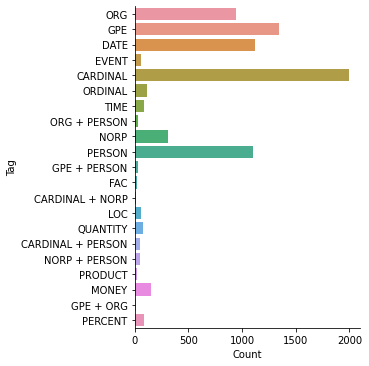

In [20]:
import seaborn as sn

def get_unique_label(group:list):
    group.sort()
    return " + ".join(group)


counts = {}

for sent in results_ex2:
    for group in sent:
        lb = get_unique_label(group)
        try: counts[lb] += 1
        except KeyError: counts[lb] = 1

threshold = 15
counts = {k: v for k,v in counts.items() if v > threshold}
counts = pd.DataFrame.from_records([{'Tag': k, 'Count': v} for k,v in counts.items()])
sn.catplot(data=counts, y='Tag', x='Count', kind='bar')

In [ ]:
idx = -1
print(dataset['sentences'][idx])
print(results_ex2[idx])

In [ ]:
for i in range(len(dataset['sentences'])):
    sent = nlp(dataset['sentences'][i])
    if [] in group_ents(sent):
        print(i)
        break

doc = nlp(dataset['sentences'][i])
print(doc)
print([[(el.text, el.ent_type_) for el in noun_chunk] for noun_chunk in doc.ents])
print([[(el.text, el.ent_type_) for el in noun_chunk] for noun_chunk in doc.noun_chunks])
print(group_ents(doc))

### 3) One of the possible post-processing steps is to fix segmentation errors. Write a function that extends the entity span to cover the full noun-compounds. Make use of compound dependency relation.

In [ ]:
doc = nlp("my prince Charming is broken")
print([(tk.text, tk.dep_) for tk in doc])
print(list(doc.noun_chunks))

### Utilities

In [ ]:
print("From load(): ", len(dataset['sentences']))
print("From read_corpus_conll(): ", len(read_corpus_conll('/content/data/test.txt')))

In [ ]:
# here i show that my loading method works perfectly
i = 0
for sent in read_corpus_conll('/content/data/test.txt'):
    if sent[0][0] == '-DOCSTART- -X- -X- O':
        i += 1
print(i)
print(len(read_corpus_conll('/content/data/test.txt')) - len(dataset['sentences']))

In [ ]:
'|'.join(["mamma", ''])